#### Team members:
* asoltas
* gchen2s
* nselva2s
* achaur2s

In [2]:
### General imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dynamic Motion Primitives for Path Learning

In this assignment, you will write your own simple implementation of dynamic motion primitives for learning three-dimensional paths.

## Discrete DMP Implementation [70 points]

Follow the description of DMPs with a discrete canonical system to write your own implementation that allows you to learn a three-dimensional DMP from a given demonstration and then generate paths based on the learned information.

In [13]:
### Write your code by filling out the following class. Your class should expose
### at least the two functions that are predefined below, but feel free
### to also add other functions and to modify the function signatures as needed.

class DiscreteDMP(object):
    def __init__(self, n_basis=30, alpha=20.0, beta=None, alpha_x=2.0, tau=1.0,):
        #         raise NotImplementedError()
        self.n_basis = n_basis
        self.alpha = alpha
        self.beta = beta if beta else alpha / 4.0
        self.alpha_x = alpha_x
        self.tau = tau
        self.sigma = 1.0  # Initial value for basis function width
        self.centers = np.linspace(0.0, 1.0, n_basis)  # Centers of basis functions
        
    def basis_functions(self, x):
        """
        Compute the activation of the Gaussian basis functions.
        :param x: The current phase value.
        :return: A vector of activations.
        """
        return np.exp(-0.5 * ((x - self.centers) / self.sigma) ** 2)



    def learn(self, y_demo, dt=0.01) -> None:
        """Learns a dynamic motion primitive.
        """
        # YOUR CODE HERE
        self.dt = dt
        self.y_demo = y_demo
        self.g = y_demo[-1]  # Final goal position
        self.y0 = y_demo[0]  # Starting position

        # velocity and acceleration 
        dy_demo = np.gradient(y_demo, dt, axis=0)
        ddy_demo = np.gradient(dy_demo, dt, axis=0)

        # Define the canonical system (x)
        time = np.arange(len(y_demo)) * dt
        x = np.exp(-self.alpha_x * time)  

        # Forcing term 
        f_target = (ddy_demo * self.dt ** 2 - self.alpha * (self.beta * (self.g - y_demo) - dy_demo)) / x[:, None]

        # Fit the weights of the basis functions using the target forcing term
        phi = np.array([self.basis_functions(xi) for xi in x])
        self.weights = np.linalg.lstsq(phi, f_target, rcond=None)[0]
        
#         raise NotImplementedError()

    def unroll(self, y0: np.ndarray, g: np.ndarray) -> np.ndarray:
        """Generates a path that starts at y0 and ends at g,
        following a learned DMP shape.

        Keyword arguments:
        y0: np.ndarray -- Initial state of the system
        g: np.ndarray -- Goal state

        Returns a numpy array representing path waypoints.

        """
        # YOUR CODE HERE
        n_steps = len(self.y_demo)-1

        # Initial conditions
        y = [y0]
        z = np.zeros_like(y0)
        x = np.exp(-self.alpha_x * np.arange(n_steps) * self.dt / self.tau)  # Phase decay

        # Reproduce trajectory
        for xi in x:
            phi = self.basis_functions(xi)
            f = np.dot(phi, self.weights)
            dz = self.alpha * (self.beta * (g - y[-1]) - z) + f * xi
            dy = dz * self.dt / self.tau
            y.append(y[-1] + dy)
            z += dz * self.dt / self.tau

        return np.array(y)
        
#         raise NotImplementedError()

## Implementation Verification [30 points]

Verify that your implementation is working correctly and investigate the factors that affect the reconstruction error.

For the evaluation, generate multiple mathematical curves and use those to represent demonstrations from which you can learn the DMP weights.

The evaluation should consist of two parts:
* Plot your results (the generated and the reconstructed curves, similar to what is shown on lecture slide 16) to qualitatively evaluate the reconstruction.
* Use a similarity metric to evaluate the curve similarity quantitatively (e.g. mean squared error).

In your evaluation, investigate how changing the number of basis functions affects the error.

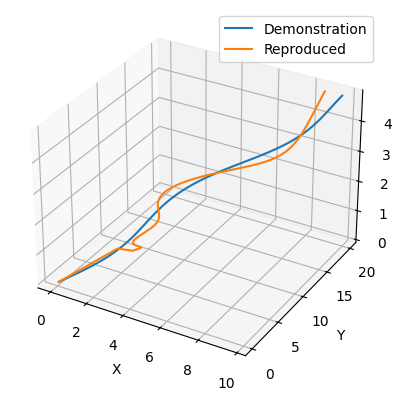

mse:  1.5689512519541127


In [14]:
### write code to test your implementation here

# YOUR CODE HERE
from sklearn.metrics import mean_squared_error
t = np.linspace(0, 10, 100)  # Time steps
x_demo = t + 0.5 * np.sin(t)  
y_demo = 2 * t + 0.2 * np.cos(t)  
z_demo = 0.5 * t + 0.1 * np.sin(0.5 * t)  

# Combine into a 3D trajectory
y_demo_3d = np.vstack([x_demo, y_demo, z_demo]).T

# Create DMP object and learn the trajectory
dmp_3d = DiscreteDMP()
dmp_3d.learn(y_demo_3d)

# Reproduce the learned trajectory
y_reproduced = dmp_3d.unroll(dmp_3d.y0, dmp_3d.g)

# Plot the demonstration and reproduced trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_demo_3d[:, 0], y_demo_3d[:, 1], y_demo_3d[:, 2], label="Demonstration")
ax.plot(y_reproduced[:, 0], y_reproduced[:, 1], y_reproduced[:, 2], label="Reproduced")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
mse = mean_squared_error(y_demo_3d, y_reproduced)
print('mse: ', mse)
# raise NotImplementedError()

Discuss the results of your evaluation here.

YOUR ANSWER HERE

The demonstrated and generated curves almost align. alpha_x parameter had major impact.

## (Optional) Rhythmic DMPs

Follow the description of DMPs with a rhythmic canonical system to write your own implementation that allows you to learn and reproduce rhythmic DMPs.

In [ ]:
class RhythmicDMP(object):
    def __init__(self):
        # YOUR CODE HERE
        raise NotImplementedError()

    def learn(self) -> None:
        """Learns a rhythmic dynamic motion primitive.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def unroll(self, y0: np.ndarray) -> np.ndarray:
        """Generates a rhythmic path that starts at y0, following a learned DMP shape.

        Keyword arguments:
        y0: np.ndarray -- Initial state of the system

        Returns a numpy array representing path waypoints.

        """
        # YOUR CODE HERE
        raise NotImplementedError()

Verify that your implementation is working correctly by experimenting with various rhythmic functions.

In [ ]:
### write code to test your implementation here

# YOUR CODE HERE
raise NotImplementedError()

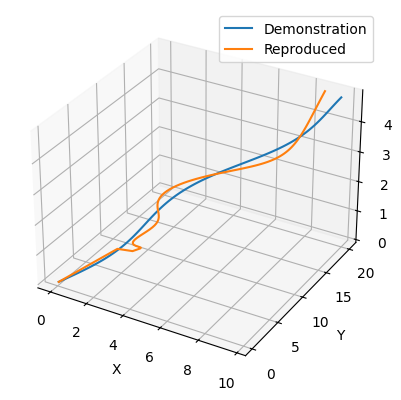

In [44]:
import numpy as np
import matplotlib.pyplot as plt

class DMP:
    def __init__(self, n_basis=20, alpha=20.0, beta=None, alpha_x=2.0):
        """
        Initialize the DMP system with parameters.
        :param n_basis: Number of basis functions (typically 20-50).
        :param alpha: Scaling factor for the system.
        :param beta: Damping factor (typically alpha/4).
        :param alpha_x: Decay constant for the canonical system.
        """
        self.n_basis = n_basis
        self.alpha = alpha
        self.beta = beta if beta else alpha / 4.0
        self.alpha_x = alpha_x
        self.sigma = 1.0  # Initial value for basis function width
        self.centers = np.linspace(0.0, 1.0, n_basis)  # Centers of basis functions

    def basis_functions(self, x):
        """
        Compute the activation of the Gaussian basis functions.
        :param x: The current phase value.
        :return: A vector of activations.
        """
        return np.exp(-0.5 * ((x - self.centers) / self.sigma) ** 2)

    def learn(self, y_demo, dt=0.01):
        """
        Learn the trajectory from a demonstration.
        :param y_demo: The demonstration trajectory.
        :param dt: Time step size.
        """
        self.dt = dt
        self.y_demo = y_demo
        self.g = y_demo[-1]  # Final goal position
        self.y0 = y_demo[0]  # Starting position

        # Compute velocity and acceleration from the demonstration
        dy_demo = np.gradient(y_demo, dt, axis=0)
        ddy_demo = np.gradient(dy_demo, dt, axis=0)

        # Define the canonical system (x)
        time = np.arange(len(y_demo)) * dt
        x = np.exp(-self.alpha_x * time)  # Phase variable

        # Forcing term computation
        f_target = (ddy_demo * self.dt ** 2 - self.alpha * (self.beta * (self.g - y_demo) - dy_demo)) / x[:, None]

        # Fit the weights of the basis functions using the target forcing term
        phi = np.array([self.basis_functions(xi) for xi in x])
        self.weights = np.linalg.lstsq(phi, f_target, rcond=None)[0]

    def reproduce(self, tau=1.0, n_steps=None):
        """
        Reproduce the trajectory based on learned weights.
        :param tau: Time scaling factor.
        :param n_steps: Number of time steps for reproduction.
        :return: The reproduced trajectory.
        """
        if n_steps is None:
            n_steps = len(self.y_demo)

        # Initial conditions
        y = [self.y0]
        z = np.zeros_like(self.y0)
        x = np.exp(-self.alpha_x * np.arange(n_steps) * self.dt / tau)  # Phase decay

        # Reproduce trajectory
        for xi in x:
            phi = self.basis_functions(xi)
            f = np.dot(phi, self.weights)
            dz = self.alpha * (self.beta * (self.g - y[-1]) - z) + f * xi
            dy = dz * self.dt / tau
            y.append(y[-1] + dy)
            z += dz * self.dt / tau

        return np.array(y)

t = np.linspace(0, 10, 100)  # Time steps

# Linear components for smoothness, with added curvature using sine functions
x_demo = t + 0.5 * np.sin(t)  # Linear with slight sine wave for curvature in x
y_demo = 2 * t + 0.2 * np.cos(t)  # Linear with slight cosine wave for curvature in y
z_demo = 0.5 * t + 0.1 * np.sin(0.5 * t)  # Linear with sine wave for curvature in z

# Combine into a 3D trajectory
y_demo_3d = np.vstack([x_demo, y_demo, z_demo]).T

# Create DMP object and learn the trajectory
dmp_3d = DMP(n_basis=30)
dmp_3d.learn(y_demo_3d)

# Reproduce the learned trajectory
y_reproduced = dmp_3d.reproduce(tau=1.0)

# Plot the demonstration and reproduced trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_demo_3d[:, 0], y_demo_3d[:, 1], y_demo_3d[:, 2], label="Demonstration")
ax.plot(y_reproduced[:, 0], y_reproduced[:, 1], y_reproduced[:, 2], label="Reproduced")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
